In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

# Functions

## Classes distribution

In [2]:
def display_pie_chart(df, column_name, title=None, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content 
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    activity_percentages_df = df[column_name].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

In [35]:
def display_pie_charts(first_df, second_df, column, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing 
        3) column - the name of the dataframe column whose percentage values are to be found
        4) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

# Read and prepare train, validation and test datasets

## Read train_data and test_data

In [59]:
train_data = pd.read_csv('data/40_Hz/model_data/train_data.csv')
train_data.head()

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,gyrZ_pos_count,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity
0,0.204513,0.043750,10.181814,-0.041990,0.191702,0.446751,2.493435,0.173847,0.164112,0.352874,...,25,0.889454,0.846221,0.324005,-0.531108,-0.783717,-0.403698,-0.816060,-0.840034,Squat
1,0.339821,0.349124,10.100784,-0.048229,0.211233,0.441290,2.552319,0.316891,0.181807,0.378584,...,26,-0.752718,-0.129656,0.268890,0.523141,-0.661552,-1.095923,-0.773074,-0.904146,Squat
2,0.316942,0.815667,9.721920,-0.079716,0.216026,0.908844,2.554711,0.334650,0.187870,0.699350,...,25,-0.348733,0.969841,0.788509,0.564838,-0.898058,0.030919,-0.327959,-0.866246,Squat
3,0.193883,0.900957,9.749154,-0.026190,0.288013,0.857635,3.219180,0.307127,0.219851,0.704377,...,30,-0.037762,1.113915,0.474904,0.199509,0.485459,-0.065963,-1.263340,-1.162199,Squat
4,0.037838,0.780090,9.024925,0.038186,0.278074,0.454869,2.237759,0.241641,0.218381,0.408583,...,31,0.504361,-0.236346,0.917411,0.420765,1.228187,-1.453429,0.955438,-0.839217,Squat


In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   accX_mean       1799 non-null   float64
 1   accY_mean       1799 non-null   float64
 2   accZ_mean       1799 non-null   float64
 3   gyrZ_mean       1799 non-null   float64
 4   accX_std        1799 non-null   float64
 5   accY_std        1799 non-null   float64
 6   accZ_std        1799 non-null   float64
 7   gyrZ_std        1799 non-null   float64
 8   accX_aad        1799 non-null   float64
 9   accY_aad        1799 non-null   float64
 10  accZ_aad        1799 non-null   float64
 11  gyrZ_aad        1799 non-null   float64
 12  accX_min        1799 non-null   float64
 13  accY_min        1799 non-null   float64
 14  accZ_min        1799 non-null   float64
 15  gyrZ_min        1799 non-null   float64
 16  accX_max        1799 non-null   float64
 17  accY_max        1799 non-null   f

In [61]:
test_data = pd.read_csv('data/40_Hz/model_data/test_data.csv')
test_data.head()

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,gyrZ_pos_count,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity
0,-0.150695,-0.657400,10.014212,0.085439,0.315760,0.598989,2.765805,0.218151,0.275360,0.470228,...,40,0.172701,-0.022567,0.225647,-0.067344,-1.180752,-0.849210,-1.101699,-1.438608,Squat
1,-0.205195,-0.864887,10.216321,0.051053,0.256426,0.546921,2.614788,0.162519,0.226416,0.481019,...,34,-0.068822,0.163635,0.128496,0.190845,-1.316665,-1.031321,-0.815560,-0.960893,Squat
2,-0.195125,-0.312677,9.114502,-0.030522,0.176494,0.580346,0.923041,0.110257,0.136129,0.465185,...,22,-0.200145,-1.038471,-0.994637,0.209813,-0.188832,-0.100558,-0.212936,-0.281949,Squat
3,0.045037,-0.215254,10.665792,0.036577,0.350643,0.488538,2.656875,0.125370,0.273218,0.344392,...,37,1.138782,-1.529475,0.795849,0.152785,0.471938,1.656329,-0.561226,-0.349502,Squat
4,0.325499,-0.878630,10.369978,-0.047531,0.403233,0.574996,3.040613,0.214552,0.333493,0.502883,...,27,0.356509,0.122926,0.399462,-0.377932,-0.626113,-1.365100,-0.797630,-0.904405,Squat


In [62]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   accX_mean       360 non-null    float64
 1   accY_mean       360 non-null    float64
 2   accZ_mean       360 non-null    float64
 3   gyrZ_mean       360 non-null    float64
 4   accX_std        360 non-null    float64
 5   accY_std        360 non-null    float64
 6   accZ_std        360 non-null    float64
 7   gyrZ_std        360 non-null    float64
 8   accX_aad        360 non-null    float64
 9   accY_aad        360 non-null    float64
 10  accZ_aad        360 non-null    float64
 11  gyrZ_aad        360 non-null    float64
 12  accX_min        360 non-null    float64
 13  accY_min        360 non-null    float64
 14  accZ_min        360 non-null    float64
 15  gyrZ_min        360 non-null    float64
 16  accX_max        360 non-null    float64
 17  accY_max        360 non-null    flo

### Add 'activity_number' column to train_data and test_data

In [63]:
activity_dict = {'Squat': 1, 'Leg land': 2, 'Walk': 3, 'Lateral squat slide': 4, 'Jogging': 5}
train_data['activity_number'] = train_data['activity'].apply(lambda x: activity_dict[x])
test_data['activity_number'] = test_data['activity'].apply(lambda x: activity_dict[x])
train_data.head()

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity,activity_number
0,0.204513,0.043750,10.181814,-0.041990,0.191702,0.446751,2.493435,0.173847,0.164112,0.352874,...,0.889454,0.846221,0.324005,-0.531108,-0.783717,-0.403698,-0.816060,-0.840034,Squat,1
1,0.339821,0.349124,10.100784,-0.048229,0.211233,0.441290,2.552319,0.316891,0.181807,0.378584,...,-0.752718,-0.129656,0.268890,0.523141,-0.661552,-1.095923,-0.773074,-0.904146,Squat,1
2,0.316942,0.815667,9.721920,-0.079716,0.216026,0.908844,2.554711,0.334650,0.187870,0.699350,...,-0.348733,0.969841,0.788509,0.564838,-0.898058,0.030919,-0.327959,-0.866246,Squat,1
3,0.193883,0.900957,9.749154,-0.026190,0.288013,0.857635,3.219180,0.307127,0.219851,0.704377,...,-0.037762,1.113915,0.474904,0.199509,0.485459,-0.065963,-1.263340,-1.162199,Squat,1
4,0.037838,0.780090,9.024925,0.038186,0.278074,0.454869,2.237759,0.241641,0.218381,0.408583,...,0.504361,-0.236346,0.917411,0.420765,1.228187,-1.453429,0.955438,-0.839217,Squat,1


#### Check the contents of the column 'activity_number'

In [64]:
train_data[train_data['activity'] == 'Leg land'][:2]

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity,activity_number
359,-0.177001,-0.071390,9.195620,0.317475,0.554876,1.766463,1.225799,1.162520,0.439605,1.349446,...,0.159380,-0.143069,0.210823,1.648702,-0.445542,-0.494156,-0.180568,1.271196,Leg land,2
360,-0.379822,-0.934833,10.700437,0.399324,0.605419,1.926286,1.334721,1.253211,0.478643,1.525032,...,0.742735,0.850448,-0.560625,1.030941,-0.310833,-0.356983,-1.029383,0.003025,Leg land,2


In [65]:
train_data[train_data['activity'] == 'Walk'][:2]

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity,activity_number
719,-0.083706,-0.791284,10.144051,0.316554,0.200114,0.835789,1.304594,1.009419,0.164816,0.733097,...,-0.429558,-0.434243,-0.303789,0.927953,-0.605224,-1.079445,-0.796267,0.431676,Walk,3
720,0.073363,-0.593874,9.441944,-0.021837,0.272772,0.895147,1.211926,0.702808,0.189157,0.769209,...,0.738310,-0.731030,-0.069251,0.203493,0.506804,-0.640683,-0.969395,-1.447900,Walk,3


In [66]:
train_data[train_data['activity'] == 'Lateral squat slide'][:2]

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity,activity_number
1079,-0.248692,-0.434817,9.777810,0.020129,0.832647,0.443501,0.840832,0.251913,0.706526,0.396119,...,-0.362168,0.059182,-0.837207,0.522958,-1.065972,-1.338965,-0.053717,1.177175,Lateral squat slide,4
1080,0.139244,-0.264266,10.066209,-0.009380,0.454232,0.527696,0.258751,0.267330,0.378166,0.471434,...,0.139501,-0.258875,0.350415,-0.933402,-0.836180,-1.338659,-0.279554,0.518720,Lateral squat slide,4


In [67]:
train_data[train_data['activity'] == 'Jogging'][:2]

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis,activity,activity_number
1439,0.210612,-0.840227,9.661613,-0.152011,1.437097,1.700642,2.663768,2.046532,1.220251,1.468716,...,-0.080321,-0.635651,-0.222238,-0.149993,-1.102121,-0.948873,-1.134584,-0.665609,Jogging,5
1440,0.329180,-1.126034,9.127768,-0.185724,1.614941,2.376296,3.020840,3.061086,1.428516,2.153004,...,-0.040189,-0.064094,-0.397093,-0.097742,-1.399152,-1.450735,-1.090312,-1.230292,Jogging,5


## Split train_data and test_data into required datasets

### Split train_data into X_train, y_train, X_valid, y_valid  

#### View the distribution of classes before dividing the train_data dataset

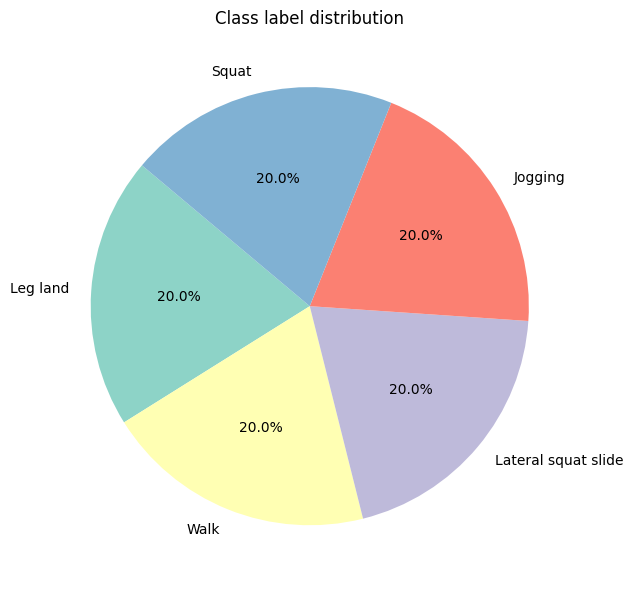

In [68]:
display_pie_chart(df=train_data, column_name='activity', title='Class label distribution')

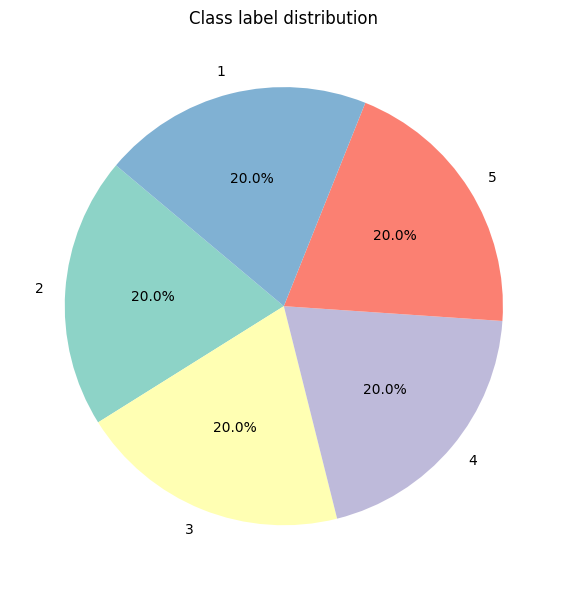

In [69]:
display_pie_chart(df=train_data, column_name='activity_number', title='Class label distribution')

#### Perform spliting

In [70]:
train_data[train_data.columns[:-2]][:5]

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accZ_pos_count,gyrZ_pos_count,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis
0,0.204513,0.043750,10.181814,-0.041990,0.191702,0.446751,2.493435,0.173847,0.164112,0.352874,...,62,25,0.889454,0.846221,0.324005,-0.531108,-0.783717,-0.403698,-0.816060,-0.840034
1,0.339821,0.349124,10.100784,-0.048229,0.211233,0.441290,2.552319,0.316891,0.181807,0.378584,...,62,26,-0.752718,-0.129656,0.268890,0.523141,-0.661552,-1.095923,-0.773074,-0.904146
2,0.316942,0.815667,9.721920,-0.079716,0.216026,0.908844,2.554711,0.334650,0.187870,0.699350,...,62,25,-0.348733,0.969841,0.788509,0.564838,-0.898058,0.030919,-0.327959,-0.866246
3,0.193883,0.900957,9.749154,-0.026190,0.288013,0.857635,3.219180,0.307127,0.219851,0.704377,...,62,30,-0.037762,1.113915,0.474904,0.199509,0.485459,-0.065963,-1.263340,-1.162199
4,0.037838,0.780090,9.024925,0.038186,0.278074,0.454869,2.237759,0.241641,0.218381,0.408583,...,62,31,0.504361,-0.236346,0.917411,0.420765,1.228187,-1.453429,0.955438,-0.839217


In [73]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for activity in train_data['activity'].unique():
    activity_data = train_data[train_data['activity'] == activity].copy()
    activity_data.reset_index(inplace=True)
    activity_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(activity_data))
    if counter != 0:
        X_train = pd.concat([X_train, activity_data[activity_data.columns[:-2]][:split_index]])
    else:
        X_train = activity_data[activity_data.columns[:-2]][:split_index]
        
    y_train.extend(list(activity_data['activity_number'].values[:split_index]))
    
    
    if counter != 0:
        X_valid = pd.concat([X_valid, activity_data[activity_data.columns[:-2]][split_index:]])
    else:
        X_valid = activity_data[activity_data.columns[:-2]][split_index:]
        
    y_valid.extend(list(activity_data['activity_number'].values[split_index:]))
    
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

len(X_train) = 1439
len(y_train) = 1439
len(X_valid) = 360
len(y_valid) = 360


In [74]:
X_train.head()

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accZ_pos_count,gyrZ_pos_count,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis
0,0.204513,0.043750,10.181814,-0.041990,0.191702,0.446751,2.493435,0.173847,0.164112,0.352874,...,62,25,0.889454,0.846221,0.324005,-0.531108,-0.783717,-0.403698,-0.816060,-0.840034
1,0.339821,0.349124,10.100784,-0.048229,0.211233,0.441290,2.552319,0.316891,0.181807,0.378584,...,62,26,-0.752718,-0.129656,0.268890,0.523141,-0.661552,-1.095923,-0.773074,-0.904146
2,0.316942,0.815667,9.721920,-0.079716,0.216026,0.908844,2.554711,0.334650,0.187870,0.699350,...,62,25,-0.348733,0.969841,0.788509,0.564838,-0.898058,0.030919,-0.327959,-0.866246
3,0.193883,0.900957,9.749154,-0.026190,0.288013,0.857635,3.219180,0.307127,0.219851,0.704377,...,62,30,-0.037762,1.113915,0.474904,0.199509,0.485459,-0.065963,-1.263340,-1.162199
4,0.037838,0.780090,9.024925,0.038186,0.278074,0.454869,2.237759,0.241641,0.218381,0.408583,...,62,31,0.504361,-0.236346,0.917411,0.420765,1.228187,-1.453429,0.955438,-0.839217


In [75]:
y_train[:5]

[1, 1, 1, 1, 1]

#### View the distribution of classes after dividing the train_data dataset

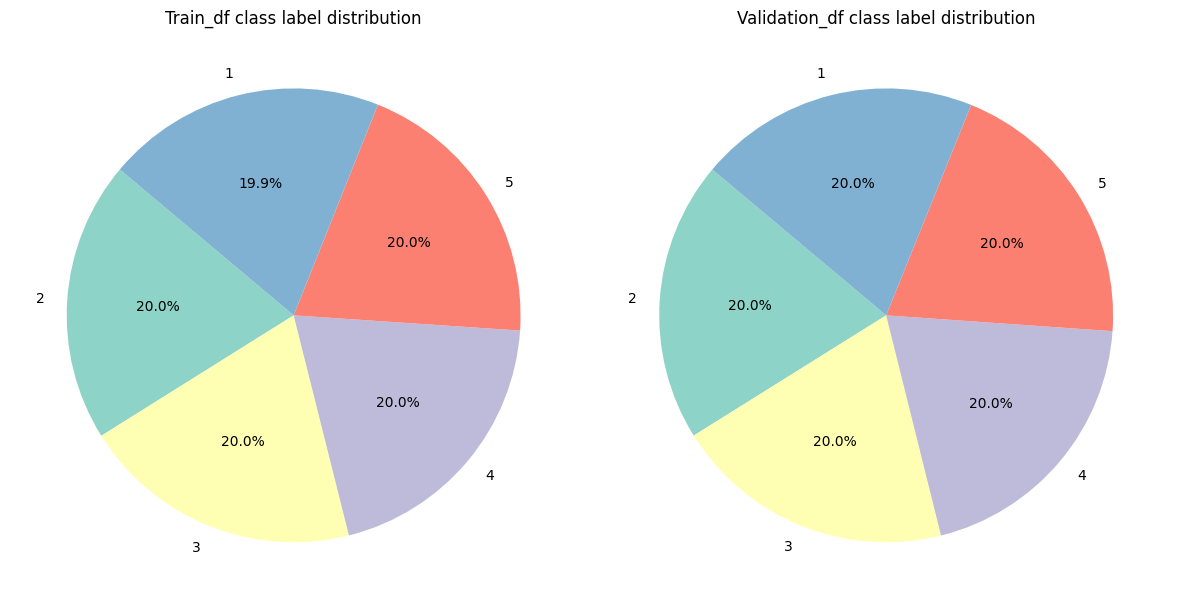

In [77]:
train_df = X_train.copy()
train_df['activity_number'] = y_train

valid_df = X_valid.copy()
valid_df['activity_number'] = y_valid

display_pie_charts(first_df=train_df, second_df=valid_df, column='activity_number', 
                   first_chart_title='Train_df class label distribution',
                   second_chart_title='Validation_df class label distribution', 
                   filename='graphs/train_valid_pie_charts')

### Split test_data into X_test, y_test

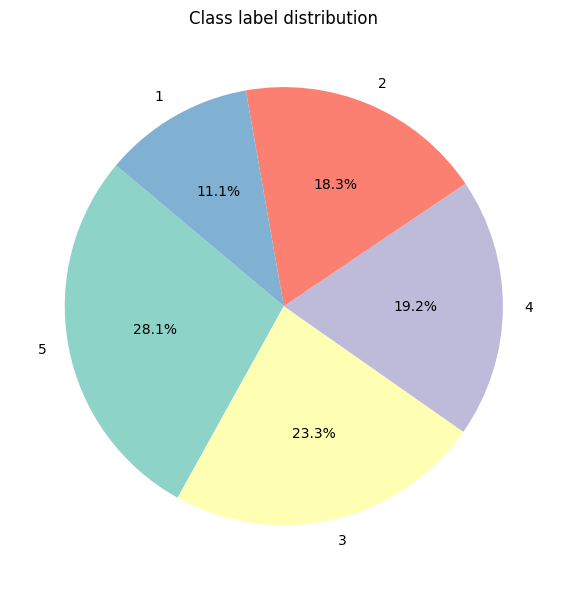

In [78]:
display_pie_chart(df=test_data, column_name='activity_number', title='Class label distribution', filename='graphs/test_pie_chart')

In [79]:
X_test = test_data[test_data.columns[:-2]]
y_test = test_data['activity_number'].values

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_test) = 360
len(y_test) = 360


In [80]:
X_test.head()

,accX_mean,accY_mean,accZ_mean,gyrZ_mean,accX_std,accY_std,accZ_std,gyrZ_std,accX_aad,accY_aad,...,accZ_pos_count,gyrZ_pos_count,accX_assymetry,accY_assymetry,accZ_assymetry,gyrZ_assymetry,accX_kurtosis,accY_kurtosis,accZ_kurtosis,gyrZ_kurtosis
0,-0.150695,-0.657400,10.014212,0.085439,0.315760,0.598989,2.765805,0.218151,0.275360,0.470228,...,61,40,0.172701,-0.022567,0.225647,-0.067344,-1.180752,-0.849210,-1.101699,-1.438608
1,-0.205195,-0.864887,10.216321,0.051053,0.256426,0.546921,2.614788,0.162519,0.226416,0.481019,...,61,34,-0.068822,0.163635,0.128496,0.190845,-1.316665,-1.031321,-0.815560,-0.960893
2,-0.195125,-0.312677,9.114502,-0.030522,0.176494,0.580346,0.923041,0.110257,0.136129,0.465185,...,61,22,-0.200145,-1.038471,-0.994637,0.209813,-0.188832,-0.100558,-0.212936,-0.281949
3,0.045037,-0.215254,10.665792,0.036577,0.350643,0.488538,2.656875,0.125370,0.273218,0.344392,...,61,37,1.138782,-1.529475,0.795849,0.152785,0.471938,1.656329,-0.561226,-0.349502
4,0.325499,-0.878630,10.369978,-0.047531,0.403233,0.574996,3.040613,0.214552,0.333493,0.502883,...,61,27,0.356509,0.122926,0.399462,-0.377932,-0.626113,-1.365100,-0.797630,-0.904405


In [81]:
y_test[:5]

array([1, 1, 1, 1, 1], dtype=int64)

## Model training

### View the sizes of the training, validation and test datasets

In [83]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 1439
len(y_train) = 1439
len(X_valid) = 360
len(y_valid) = 360
len(X_test) = 360
len(y_test) = 360
